# Breast Cancer Detection with KNN - Classification Challange

## Description

Breast cancer is the most common cancer amongst women in the world. It accounts for 25% of all cancer cases, and affected over 2.1 Million people in 2015 alone. It starts when cells in the breast begin to grow out of control. These cells usually form tumors that can be seen via X-ray or felt as lumps in the breast area.

The key challenges against it’s detection is how to classify tumors into malignant (cancerous) or benign(non cancerous). We ask you to complete the analysis of classifying these tumors using machine learning (with SVMs) and the Breast Cancer Wisconsin (Diagnostic) Dataset.

## Acknowledgements

This dataset has been referred from Kaggle.

## Objective

- Understand the Dataset & cleanup (if required).
- Build classification models to predict whether the cancer type is Malignant or Benign.
- Also fine-tune the hyperparameters & compare the evaluation metrics of various classification algorithms.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn import metrics as mt

## Load Dataset

In [2]:
dataset_path = './breast-cancer.csv'

df = pd.read_csv(dataset_path)

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

### Checking if the dataset is balance or unbalance

B -> benign     (non cancerous)
M -> malignant  (cancerous)

In [4]:
df.loc[:, ['id' ,'diagnosis']].groupby('diagnosis').count().reset_index()

,diagnosis,id
0,B,357
1,M,212


## Seleção de Features

In [ ]:
# x = features_treinamento
# y = label

features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'
       ]

label = 'diagnosis'

#x_train = df.loc[:, features]
#y_train = df.loc[:, label]

## Treinamento

### Spliting the Data into -> Training, test, validate

"Numpy solution"
Will shuffle the whole dataset first `df.sample(frac=1, random_state=42)` and then split the data set into the following parts:
- 60% -> train set;
- 20% -> validation set;
- 20% -> test set;

In [15]:
train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

x_train = train.loc[:, features]
y_train = train.loc[:, label]

x_validate = validate.loc[:, features]
y_validate = validate.loc[:, label]

x_test = test.loc[:, features]
y_test = test.loc[:, label]

d:\Anaconda\envs\git\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [13]:
train.shape

(341, 32)

In [12]:
validate.shape

(114, 32)

In [14]:
test.shape

(114, 32)

## KNN Training

### Finding best k for imbalanced dataset

#### Sensitivity-Specificity Metrics

Sensitivity refers to the true positive rate and summarizes how well the positive class was predicted.

$$
Sensitivity = \frac{TruePositive}{TruePositive + FalseNegative}
$$

Specificity is the complement to sensitivity, or the true negative rate, and summarises how well the negative class was predicted.

$$
Specificity = \frac{TrueNegative}{FalsePositive + TrueNegative}
$$

For imbalanced classification, the sensitivity might be more interesting than the specificity.

Sensitivity and Specificity can be combined into a single score that balances both concerns, called the geometric mean or G-Mean.

$$
G_Mean = sqrt(Sensitivity * Specificitu)
$$

In [16]:
# definindo parametros do treinamento
k = 4
knn_classifier = KNeighborsClassifier( n_neighbors = k )

# treinamento do algoritmo
knn_classifier.fit( x_train, y_train )

y_pred = knn_classifier.predict(x_train)

cm = mt.confusion_matrix(y_train,y_pred)

TP = cm[0][0]
FN = cm[0][1]
TN = cm[1][1]
FP = cm[1][0]

SENSITIVITY = TP / (TP + FN)

print(f'SENSITIVITY = {SENSITIVITY}')

#recall = mt.recall_score(y_train, y_pred)

#print(f'reacll = ;{recall}')


SENSITIVITY = 0.9908256880733946


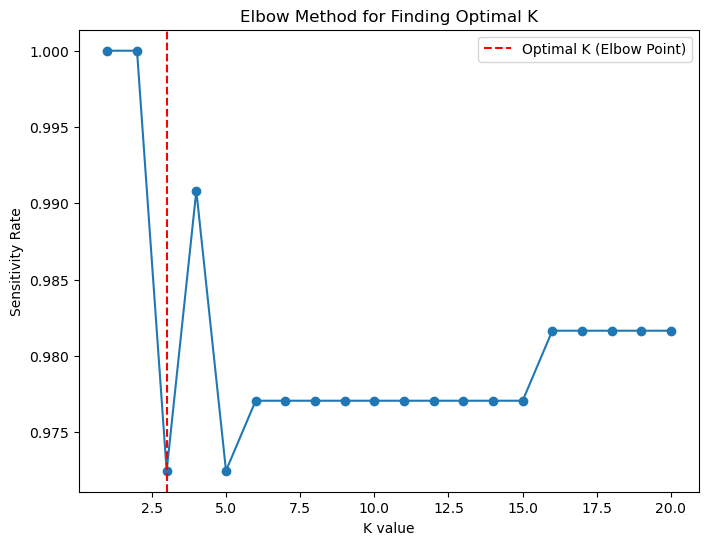

In [20]:
# definindo parametros do treinamento

k_values = range(1, 21)
error_rates = []
sensitivity_rates = []

for k in k_values:
  knn_classifier = KNeighborsClassifier( n_neighbors = k )

  # treinamento do algoritmo
  knn_classifier.fit( x_train, y_train )

  y_pred = knn_classifier.predict(x_train)

  cm = mt.confusion_matrix(y_train,y_pred)

  TP = cm[0][0]
  FN = cm[0][1]
  TN = cm[1][1]
  FP = cm[1][0]

  SENSITIVITY = TP / (TP + FN)
  sensitivity_rates.append(SENSITIVITY)

plt.figure(figsize=(8,6))
plt.plot(k_values, sensitivity_rates, marker='o')
plt.xlabel('K value')
plt.ylabel('Sensitivity Rate')
plt.title('Elbow Method for Finding Optimal K')
plt.axvline(x=3, linestyle='--', color='red', label='Optimal K (Elbow Point)')
plt.legend()
plt.show()

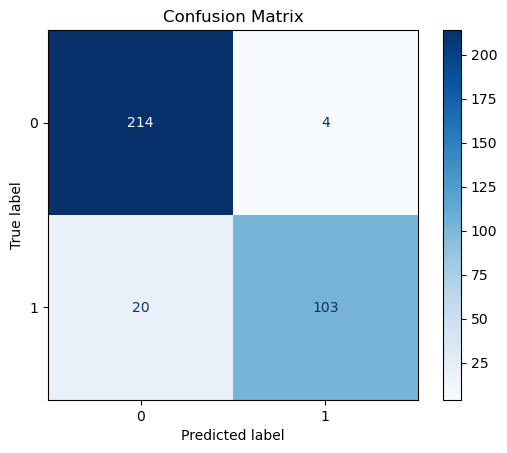

In [ ]:
disp = mt.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [36]:
# definindo parametros do treinamento
k = 4
knn_classifier = KNeighborsClassifier( n_neighbors = k )

# treinamento do algoritmo
knn_classifier.fit( x_train, y_train )

,n_neighbors,4
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [73]:
y_pred = knn_classifier.predict(x_test)

In [75]:
#df_result = train.copy()
df_result = test.copy()
df_result['classificacao'] = y_pred

## Performance

### Matriz de confusão

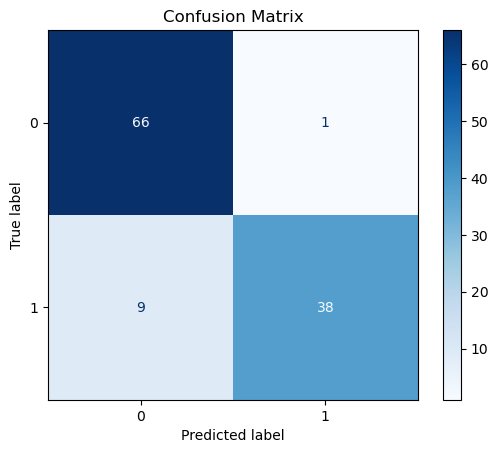

In [108]:
c_m = mt.confusion_matrix(y_test,y_pred)
disp = mt.ConfusionMatrixDisplay(confusion_matrix=c_m)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Acurácia

In [78]:
mt.accuracy_score(y_test, y_pred)

0.9122807017543859

# Sensitivity

In [79]:
cm = mt.confusion_matrix(y_test,y_pred)

TP = cm[0][0]
FN = cm[0][1]
TN = cm[1][1]
FP = cm[1][0]

SENSITIVITY = TP / (TP + FN)

print(f'SENSITIVITY = {SENSITIVITY}')

SENSITIVITY = 0.9850746268656716


### Recall

In [81]:
#mt.recall_score(y_test,y_pred)

In [82]:
df_result.loc[:, ['id', 'diagnosis','classificacao']].sample(10)

,id,diagnosis,classificacao
418,906024,B,B
288,8913049,B,B
378,9013594,B,B
187,874373,B,B
207,879830,M,M
276,8911230,B,B
243,88411702,B,B
303,892657,B,B
241,883539,B,B
445,9110720,B,B


In [83]:
df_result['acertos'] = (df_result.loc[:, ['id', 'diagnosis', 'classificacao']]
                        .apply(
                          lambda x: 1 if x['diagnosis'] == x['classificacao'] else 0, axis=1
                          )
                      )

In [84]:
df_result.loc[:, ['id', 'diagnosis', 'classificacao','acertos']].sample(10)

,id,diagnosis,classificacao,acertos
389,90312,M,M,1
337,897630,M,M,1
241,883539,B,B,1
401,904647,B,B,1
190,874858,M,B,0
303,892657,B,B,1
191,875093,B,B,1
295,891923,B,B,1
537,919812,B,B,1
372,9012795,M,M,1


In [85]:
acertos = df_result['acertos'].sum()

print(f'Total de acertos = {acertos}')

Total de acertos = 104


In [86]:
df_result.shape

(114, 34)

In [87]:
print(f'Acuracia = {(acertos / df_result.shape[0])}')

Acuracia = 0.9122807017543859


In [99]:
df_result.loc[:, ['diagnosis', 'id', 'classificacao']].groupby(['diagnosis', 'classificacao']).count()

id
diagnosis classificacao    
B         B              66
          M               1
M         B               9
          M              38

Por volta de 20% dos M eu classifiquei errado